In [2]:
import torch
import kagglehub
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [3]:
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Download latest version
path = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis


In [5]:
dataset_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis"
count = 0

for root, dirs, files in os.walk(dataset_path):
    if count >= 10:
        break
    for file in files:
        if file.endswith(".png"):
            print("Rutas encontradas con las imagenes")
            print("-", os.path.join(root, file))
            count += 1
            if count >= 10:
                break

Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/428.0.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/41.7.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/654.5.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/604.7.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/740.0.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/188.3.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/541.8.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-com

In [6]:
train_path = os.path.join(dataset_path, "PolyMNIST", "MMNIST", "train")
modalities = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
print("Modalidades encontradas:", modalities)

Modalidades encontradas: ['m4', 'm2', 'm0', 'm1', 'm3']


In [7]:
dataset_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis"
base_path = os.path.join(dataset_path, "PolyMNIST", "MMNIST")

data = []

for split in ["train", "test"]:
    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path):
        continue
    for modality in os.listdir(split_path):
        modality_path = os.path.join(split_path, modality)
        if not os.path.isdir(modality_path):
            continue
        for file in os.listdir(modality_path):
            if file.endswith(".png"):
                try:
                    label = int(file.split(".")[1])  # Ej: 1234.5.png → 5
                    full_path = os.path.join(modality_path, file)
                    data.append({
                        "file_path": full_path,
                        "label": label,
                        "modality": modality,
                        "split": split
                    })
                except Exception as e:
                    print(f"Error con archivo: {file} → {e}")

df = pd.DataFrame(data)
print("DataFrame generado con", len(df), "registros.")
print(df.head())

DataFrame generado con 350000 registros.
                                           file_path  label modality  split
0  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train
1  /kaggle/input/mnist-multiple-dataset-comprehen...      0       m4  train
2  /kaggle/input/mnist-multiple-dataset-comprehen...      0       m4  train
3  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train
4  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train


In [8]:
class PolyMNISTDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'file_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

train_dataset = PolyMNISTDataset(train_df, transform)
test_dataset = PolyMNISTDataset(test_df, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Red Fully-Connected

In [10]:
class FCNet(nn.Module):
    def __init__(self, input_dim=28*28*3, hidden_dims=[1024, 512], num_classes=10, p_drop=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], num_classes)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        # x: [B, 3, 28, 28] → [B, 2352]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = FCNet().to(DEVICE)
print(model)


FCNet(
  (fc1): Linear(in_features=2352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Pérdida y optimizador

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## Bucle de entrenamiento y validación

In [12]:
num_epochs = 10

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, num_epochs+1):
    # ——— Entrenamiento ———
    model.train()
    running_loss, running_correct = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * imgs.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc  = running_correct / len(train_loader.dataset) * 100

    # ——— Validación ———
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            val_loss    += criterion(outputs, labels).item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
    val_loss /= len(test_loader.dataset)
    val_acc  = val_correct / len(test_loader.dataset) * 100

    # ——— Guardar historial ———
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.2f}% | "
          f"Val: loss={val_loss:.4f}, acc={val_acc:.2f}%")


Epoch 1/10 — Train: loss=0.7145, acc=77.27% | Val: loss=0.5169, acc=83.63%
Epoch 2/10 — Train: loss=0.5369, acc=83.07% | Val: loss=0.4611, acc=85.49%
Epoch 3/10 — Train: loss=0.4796, acc=84.93% | Val: loss=0.4215, acc=86.68%
Epoch 4/10 — Train: loss=0.4437, acc=86.14% | Val: loss=0.4257, acc=87.29%
Epoch 5/10 — Train: loss=0.4199, acc=87.04% | Val: loss=0.3756, acc=88.58%
Epoch 6/10 — Train: loss=0.4026, acc=87.66% | Val: loss=0.3673, acc=89.07%
Epoch 7/10 — Train: loss=0.3877, acc=88.18% | Val: loss=0.3592, acc=89.29%
Epoch 8/10 — Train: loss=0.3741, acc=88.56% | Val: loss=0.3872, acc=88.61%
Epoch 9/10 — Train: loss=0.3650, acc=88.96% | Val: loss=0.3726, acc=89.67%
Epoch 10/10 — Train: loss=0.3576, acc=89.39% | Val: loss=0.3616, acc=89.75%


## Plots de pérdida y precisión

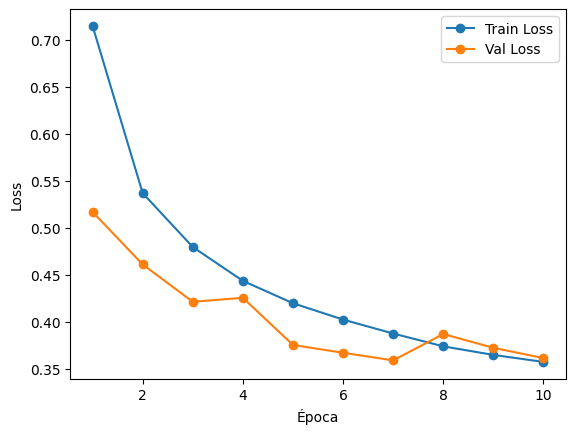

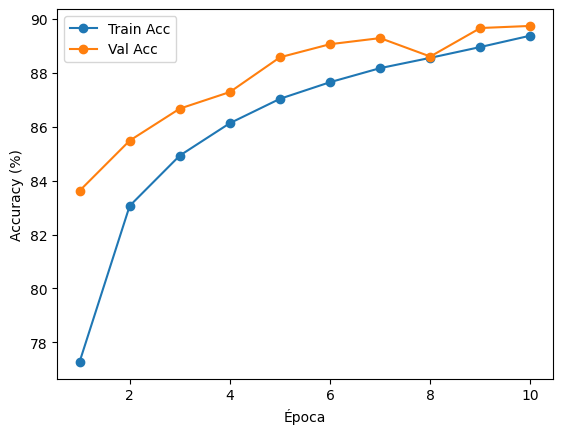

In [13]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs+1))

plt.figure()
plt.plot(epochs, history["train_loss"], marker='o', label="Train Loss")
plt.plot(epochs, history["val_loss"],   marker='o', label="Val Loss")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history["train_acc"], marker='o', label="Train Acc")
plt.plot(epochs, history["val_acc"],   marker='o', label="Val Acc")
plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.show()


## Tests de Predicción

In [14]:
def predict_random_image(model, dataset, class_names=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        predicted = torch.argmax(output, 1).item()

    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5 + 0.5).clip(0, 1)

    plt.imshow(image_np)
    plt.title(f"Real: {label} | Predicho: {predicted}")
    plt.axis('off')
    plt.show()

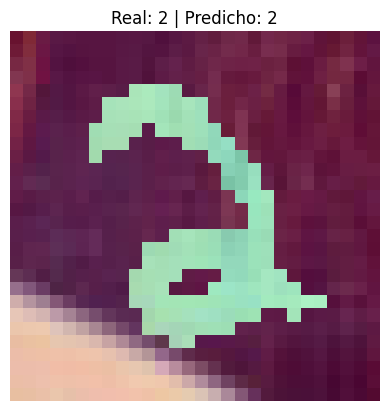

In [19]:
predict_random_image(model, test_dataset)